<a href="https://colab.research.google.com/github/Waidhoferj/CSC-566-Project/blob/facial-filtering/FacialLandmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Landmarks
Experimentation with facial landmarks models and datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers
from google.colab import drive
import os
from scipy.io import loadmat
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Add your name and filepath to the project folder so that you can load the datasets.


In [3]:
USER = "Ty"
USER_FILEPATHS = {
    "John" : "/content/drive/MyDrive/CSC 566 Project",
    "Jeremy" : "/content/drive/MyDrive/School/Undergrad/2021 Spring/CSC 566/CSC 566 Project",
    "Ty" : "/content/drive/MyDrive/CSC 566 Project"
}
PROJECT_FILEPATH = USER_FILEPATHS[USER]

## Data Preparation

In [11]:
# Sanity check for loading data
def display_landmarks(img, points):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)
  for p in points:
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()

#points = loadmat(AFW_DATASET + "/70037463_1.mat")["pt2d"]
#img  = plt.imread( AFW_DATASET+"/70037463_1.jpg")

#display_landmarks(img,points)



In [ ]:
import tensorflow as tf

DATALOADER_BASE_PATH = PROJECT_FILEPATH + "/datasets/tf-datasets"
USE_CROPPED_IMAGES = True
DATASET_PREFIX = "cropped-" if USE_CROPPED_IMAGES else ""

class DataLoader:

  IMAGE_SHAPE = (256, 256, 3) if USE_CROPPED_IMAGES else (450, 450, 3)
  LANDMARKS_SHAPE = (136,)

  BATCH_SIZE = 64
  TRAIN_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}train-{i}.tfrecord.gz" for i in range(5)]
  VAL_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}val-{i}.tfrecord.gz" for i in range(5)]
  TEST_PATHS = [f"{DATALOADER_BASE_PATH}/{DATASET_PREFIX}test-{i}.tfrecord.gz" for i in range(5)]

  def load_datasets():
    dl = DataLoader()
    return (dl.__load_dataset(DataLoader.TRAIN_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.VAL_PATHS, DataLoader.BATCH_SIZE),
            dl.__load_dataset(DataLoader.TEST_PATHS, 1))

  def __load_dataset(self, filepath, batch_size):
    dataset = tf.data.TFRecordDataset([filepath], compression_type="GZIP")
    dataset = dataset.map(self.__parse_example, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(self.__reshape_entry, num_parallel_calls=tf.data.AUTOTUNE)
    images = dataset.map(lambda x,y: x).batch(DataLoader.BATCH_SIZE)
    labels = dataset.map(lambda x,y: y).batch(DataLoader.BATCH_SIZE)
    dataset = tf.data.Dataset.zip((images, labels))
    dataset.cache() # Cache the above map operations so they aren't re-run every epoch
    return dataset


  def __parse_example(self, record):
    feature_names = {}
    feature_names['image'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    feature_names['landmarks'] = tf.io.FixedLenSequenceFeature([],tf.float32, allow_missing=True)
    return tf.io.parse_single_example(record, feature_names)

  def __reshape_entry(self, entry):
    image = tf.reshape(entry['image'], DataLoader.IMAGE_SHAPE)
    landmarks = tf.reshape(entry['landmarks'], DataLoader.LANDMARKS_SHAPE)
    return image, landmarks


train_data, val_data, test_data = DataLoader.load_datasets()
for i,record in enumerate(val_data):
  print(record[0].shape)

(64, 450, 450, 3)
(64, 450, 450, 3)
(64, 450, 450, 3)
(58, 450, 450, 3)


## Basic Benchmark Model
From [this medium article](https://towardsdatascience.com/detecting-facial-features-using-deep-learning-2e23c8660a7a)

In [4]:
def create_basic_landmark_model(input_shape, conv_range):
  input_layer = layers.Input(input_shape)
  x = input_layer
  for exp in conv_range:
    x = layers.Conv2D(2**exp, (3,3), 3, activation="relu")(x)
    x = layers.MaxPool2D(padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(500, activation="relu")(x)
  x = layers.Dense(90, activation="relu")(x)
  x = layers.Dense(68*2, activation="relu")(x)
  return Model(name="landmark_locator", inputs=input_layer, outputs=x)



In [5]:
INPUT_SHAPE = (256, 256, 3) 
basic_model = create_basic_landmark_model(INPUT_SHAPE, range(5,8))
basic_model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
basic_model.summary()

Model: "landmark_locator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 85, 85, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 43, 43, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)    

In [ ]:
# Training
basic_model.fit(train_data.shuffle(64), epochs=30, validation_data=val_data, verbose=1)
basic_model.save_weights(PROJECT_FILEPATH + "/basic-weights.h5")

In [6]:
# Running
basic_model.load_weights(PROJECT_FILEPATH + "/basic-weights.h5")

In [ ]:
import cv2 as cv
from matplotlib import pyplot as plt

bounding_boxes = []

# load the pre-trained model from https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/
classifier = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv.VideoCapture(PROJECT_FILEPATH + "/webCamData/inputVideo.mp4")
if not cap.isOpened():
    print("Cannot open camera")
    exit()

frameCount = 0
cropped_imgs = []
original_imgs = []
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    original_imgs.append(frame)

    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    #grayscale image
    gray_image = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    #face_cascade.detectMultiScale requires unisigned integer
    gray_image = np.array(gray_image, dtype='uint8') 

    #Testing purposes DELETE
    #from matplotlib import pyplot as plt
    #plt.imshow(gray_image)
    #plt.show()

    # perform face detection
    bboxes = classifier.detectMultiScale(gray_image)

    # using the bounding box, crop the image for each detected face
    for box in bboxes:
      x, y, width, height = box
      x2, y2 = x + width, y + height
      cropped_img = frame[y:y+height, x:x+width]
      bounding_boxes.append([x, y, width, height])

    cropped_img = cv.resize(cropped_img, (256, 256))

    cropped_imgs.append(cropped_img)

    #Testing purposes: DELETE
    #from matplotlib import pyplot as plt
    #plt.imshow(cropped_img)
    #plt.show()

    # Saving the image
    cv.imwrite(PROJECT_FILEPATH + "/webCamData/webCamFrames/frame_" + str(frameCount) + ".jpg", cropped_img)
    frameCount = frameCount + 1
    
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

In [24]:
cropped_imgs = tf.convert_to_tensor(cropped_imgs)

In [72]:
predictions = basic_model.predict(cropped_imgs)

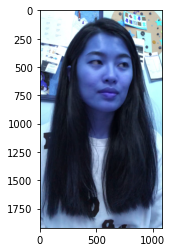

[288, 224, 907, 843]
[0. 0.]
[288. 224.]
=====
[  0.      106.84216]
[288.      330.84216]
=====
[  0.      111.47993]
[288.      335.47992]
=====
[  0.     159.3401]
[288.     383.3401]
=====
[0. 0.]
[288. 224.]
=====
[  0.      110.97056]
[288.      334.97055]
=====
[ 13.236559 134.19304 ]
[301.23657 358.19305]
=====
[ 28.844168 192.79747 ]
[316.84418 416.7975 ]
=====
[ 29.576319 150.59703 ]
[317.57632 374.59705]
=====
[9.399179 0.      ]
[297.39917 224.     ]
=====
[ 21.078138 155.0192  ]
[309.07812 379.0192 ]
=====
[ 61.338734 131.90044 ]
[349.33875 355.90045]
=====
[ 37.058453 120.17174 ]
[325.05844 344.17175]
=====
[ 88.4102  117.95014]
[376.41022 341.95013]
=====
[ 85.127754 138.20895 ]
[373.12775 362.20895]
=====
[66.61372 78.54865]
[354.6137  302.54865]
=====
[106.86472   62.023422]
[394.86472 286.02344]
=====
[0. 0.]
[288. 224.]
=====
[ 9.850196 39.666904]
[297.8502 263.6669]
=====
[ 6.667914 13.949115]
[294.6679  237.94911]
=====
[20.9288   64.440254]
[308.9288  288.44025]
=

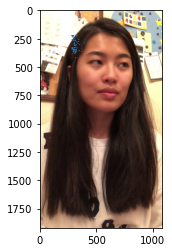

In [73]:
from matplotlib import pyplot as plt
plt.imshow(original_imgs[0])
plt.show()

def display_landmarks2(img, points, bbox):
  """
  Displays portrait with landmark dots drawn on the face.
  Assumes that points are in (68,2)
  """
  #If we are reading from .mat files directly (2,68)
  if points.shape[0] == 2:
    points = points.transpose(1,0)
  #If reading from model output
  elif len(points.shape) == 1:
    points = points.reshape(-1,2)
  fig,ax = plt.subplots(1)
  ax.set_aspect('equal')
  ax.imshow(img)

  print(bbox)
  for p in points:
      print(p)
      p[0] = p[0] + bbox[0]
      p[1] = p[1] + bbox[1]
      print(p)
      print("=====")
      circ = Circle(p)
      ax.add_patch(circ)
  plt.show()


display_landmarks2(tf.reverse(original_imgs[0], [2]), predictions[0], bounding_boxes[0])

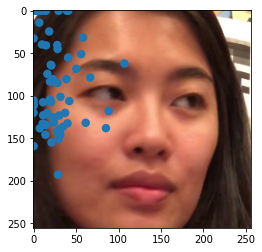

In [27]:
count = 0
for i in range(len(cropped_imgs)):
  if count == 1:
    break
  count += 1

  display_landmarks(tf.reverse(cropped_imgs[i], [2]), predictions[i])
#display_landmarks(tf.reverse(cropped_imgs[0], [2]), predictions[0])

### Analyze Results

In [ ]:
pd.DataFrame(basic_model.history.history).plot()

In [ ]:
predictions = basic_model.predict(test_data.map(lambda x,y: x))

In [ ]:
#@title View Predicted Images
image_index = 3 #@param {type:"slider", min:1, max:16, step:1}
points = predictions * 450
i = 0
for x in test_data.map(lambda x,y: x):
  if (i == image_index):
    display_landmarks(tf.reshape(x, DataLoader.IMAGE_SHAPE), points[image_index])
    break
  i += 1